# Problema de los tres cuerpos restringido

El problema de los tres cuerpos plantea determinar el comportamiento de tres masas que interactúan gravitacionalmente. El caso restringido sugiere que uno de los cuerpos posee una masa tan pequeña, que la trayectoria de sus compañeras puede aproximarse a aquella que tendrían si no existiera la tercera masa. Sin embargo, el tercer cuerpo sí se mueve en el potencial gravitacional de los otros dos. 

En resumidas cuentas, hablamos del caso restringido cuando $m_3<< M_1, M_2$
Para resolver este problema, consideremos las siguientes ecuaciones:       
$\ddot x_1=\frac{GM2(x_1-x_2)}{((x_1-x_2)^2+(y_1-y_2)^2)^{(3/2)}}\\\ddot y_1=\frac{GM2(y_1-y_2)}{((x_1-x_2)^2+(y_1-y_2)^2)^{(3/2)}}\\\ddot x_2=\frac{GM1(x_2-x_1)}{((x_2-x_1)^2+(y_2-y_3)^2)^{(3/2)}}\\\ddot y_2=\frac{GM1(y_2-y_1)}{((x_2-x_1)^2+(y_2-y_1)^2)^{(3/2)}}$ 

Que provienen de hacer un simple análisis de fuerzas que siente cada cuerpo, debido a los demás (excluyendo a las fuerzas debidas a $m_3$).

Para encontrar la solución, necesitamos condiciones iniciales y condiciones impuestas, es decir:

1) Todos los cuerpos se mueven.

2) Uno de los cuerpos masivos y la masa $m_3$ pueden moverse.

3) Los dos cuerpos masivos se quedan estáticos y el cuerpo la masa $m_3$ puede moverse.

## Método de resolución

Se utilizó el módulo *TaylorSeries* para la resolución de las ecuaciones diferenciales. También se utilizaron los módulos *Compat (para poder utilizar código de otras versiones de Julia $\sim$ se utilizó la versión Julia O.3.11 para el presente proyecto$\sim$) y Pyplot  (para los gráficos).

In [1]:
using PyPlot

INFO: Loading help data...


In [2]:
using TaylorSeries 

In [3]:
using Compat

In [4]:
#Definimos constantes útiles.
const _ordenTaylor = 30
const _epsAbs = 1.0e-20 #Epsilon de la máquina, para calcular el tamaño del paso.
const GM1=1.0 #Por simplicidad comenzaré diciendo que esto es uno.
const GM2=1.0 #Y que ambos cuerpos masivos tienen la misma masa... aunque esto se puede cambiar aquí en cualquier
#momento

1.0

Definimos más funciones útiles:

In [5]:
function taylorStepper{T<:Real}( jet::Function, vec01::Array{T,1},vec02::Array{T,1},vec03::Array{T,1}) 
    #Las entradas serán una función y tres vectores 
    #cuyas entradas serán las condiciones iniciales de velocidad y posición en x y en y
    n = length( vec01 )
    vec0T1 = Array(Taylor1{T},n)
    vec0T2 = Array(Taylor1{T},n)
    vec0T3 = Array(Taylor1{T},n)
   
    @simd for i in eachindex(vec01) #Trabajamos siempre con vectores de 4 elementos
        @inbounds vec0T1[i] = Taylor1([vec01[i]], _ordenTaylor)
        @inbounds vec0T2[i] = Taylor1([vec02[i]], _ordenTaylor)
        @inbounds vec0T3[i] = Taylor1([vec03[i]], _ordenTaylor)
    end
     #A cada entrada de vec0 se le convierte a formato de serie de Taylor.
    #vec0T será un vector cuyas entradas son series de Taylor y las componentes independientes de cada uno de ellas
    #son las componentes iniciales. Por ejemplo: vec0T=[x0+ ϑ(t²⁹),y0+ϑ(t²⁹),v0x+ϑ(t²⁹),v0y+ϑ(t²⁹)]
    vec1T1,vec1T2,vec1T3 = jet(vec01,vec02,vec03 )
    #Aplicamos la función jet a vec0.
    #Va a construir el resto de los coeficientes de cada serie.
    hh = Inf
    @simd for i in eachindex(vec1T1)
        @inbounds h1 = stepsize( vec1T1[i], _epsAbs ) #Stepsize regresa el paso para una serie dada.
        #Esta parte da un valor de h para cada una de las 4 series que se encuentran en el arreglo.
        hh= min( hh, h1 ) #Luego escogemos el mínimo
    end
    hh1=hh
    hh = Inf
    @simd for i in eachindex(vec1T2)
        @inbounds h1= stepsize( vec1T2[i], _epsAbs )  
        hh= min( hh, h1 ) 
    end
    hh2=hh
    hh = Inf
    @simd for i in eachindex(vec1T3)
        @inbounds h1= stepsize( vec1T3[i], _epsAbs )  
        hh= min( hh, h1 ) 
    end
    hd=min(hh1,hh2,hh) #Obtenemos un paso de cada serie; escogemos el más chico.
    
    @simd for i in eachindex(vec01)
        @inbounds vec01[i] = evaluate( vec1T1[i], hd ) #Evalúa vec1T (obtenido en el jet) en el valor de paso
        #y lo coloca en la entrada correspondiente de vec0 (donde teníamos los valores iniciales). Ahora
        #el vec0 es el valor de las posiciones y velocidades evaluadas en el tiempo hd (avance en el tiempo)
    end
    
    @simd for i in eachindex(vec02)
        @inbounds vec02[i] = evaluate(vec1T2[i], hd)
    end

    @simd for i in eachindex(vec03)
        @inbounds vec03[i] = evaluate( vec1T3[i], hd)
    end
    
    return hd,vec01,vec02,vec03 #El paso del tiempo es el mínimo de cada serie de Taylor (así los tres cuerpos
    #avanzan en el tiempo igual)
end
#Importante saber: Esta función regresa el paso de tiempo y los vectores de velocidades y posiciones de cada masa
#Evaluados en ese paso de tiempo. Lo hace gracias a que la función Jet construye las series de cada variable.

taylorStepper (generic function with 1 method)

In [6]:
#Calcula el tamaño del paso
function stepsize{T<:Real}(x::Taylor1{T}, epsilon::Float64)
    #Tiene como entradas una serie de Taylor y la epsilon de lxa máquina
    ord = x.order
    h = Inf
    for k in [ord-1, ord] #De las dos últimas entradas 
        kinv = 1.0/k
        aux = abs(x.coeffs[k+1])
        h = min(h, (epsilon/aux)^kinv)
        #Literalmente sigue la fórmula del valor h
    end
    return h
end
#Importante saber: Si se le da como argumento una serie de Taylor, regresa el paso apropiado para esa serie en 
#particular. Se utiliza en la función TaylorStepper para calcular el paso de cada una de las series (en total 12).

stepsize (generic function with 1 method)

In [33]:
#Esta función construye las series de Taylor que después serán evaluadas (en taylorStepper)

function jet{T<:Real}(vec1::Array{T,1}, vec2::Array{T,1}, vec3::Array{T,1}) #Hay tres vectores de entrada.
    #Se transforma cada una de las entradas de los vectores a series de Taylor del orden deseado.
    xT1= Taylor1(vec1[1], _ordenTaylor) #Del primer cuerpo M1
    yT1= Taylor1(vec1[2], _ordenTaylor) 
    vxT1= Taylor1(vec1[3], _ordenTaylor)
    vyT1= Taylor1(vec1[4], _ordenTaylor)
    
    xT2= Taylor1(vec2[1], _ordenTaylor) #Del segundo M2
    yT2= Taylor1(vec2[2], _ordenTaylor)
    vxT2= Taylor1(vec2[3], _ordenTaylor)
    vyT2= Taylor1(vec2[4], _ordenTaylor)

    xT3= Taylor1(vec3[1], _ordenTaylor) #Del tercero m3 (el orden realmente no importa jeje)
    yT3= Taylor1(vec3[2], _ordenTaylor)
    vxT3= Taylor1(vec3[3], _ordenTaylor)
    vyT3= Taylor1(vec3[4], _ordenTaylor)
    #Se guardan los valores iniciales en el lugar del término independiente. Pero a medida que avanza el loop de
    #abajo, se van llenando con el resto de los términos de la serie de Taylor.
    for k = 0:_ordenTaylor-1
        knext = k+1 #Esto se necesita por el hecho de empezar desde cero.

        xTt1= Taylor1(xT1.coeffs[1:k+1], k) #Se "copian" los términos de la serie que ya se tenían
        yTt1= Taylor1(yT1.coeffs[1:k+1], k)
        vxTt1= Taylor1(vxT1.coeffs[1:k+1], k)
        vyTt1= Taylor1(vyT1.coeffs[1:k+1], k)
        
        xTt2= Taylor1(xT2.coeffs[1:k+1], k) 
        yTt2= Taylor1(yT2.coeffs[1:k+1], k)
        vxTt2= Taylor1(vxT2.coeffs[1:k+1], k)
        vyTt2= Taylor1(vyT2.coeffs[1:k+1], k) 
        
        xTt3= Taylor1(xT3.coeffs[1:k+1], k) 
        yTt3= Taylor1(yT3.coeffs[1:k+1], k)
        vxTt3= Taylor1(vxT3.coeffs[1:k+1], k)
        vyTt3= Taylor1(vyT3.coeffs[1:k+1], k)
        
        
        #Las ecuaciones de movimiento

        xDot1 = vxTt1 
        yDot1 = vyTt1
        rrt1 = ( (xTt1-xTt2)^2 + (yTt1-yTt2)^2 )^(3/2)
        k1=(xTt1-xTt2)/rrt1
        k2=(yTt1-yTt2)/rrt1
        #vxDot1 = -GM2*k1 #Los tres se mueven
        #vyDot1 = -GM2*k2
        vxDot1 = 0*k1 # M1 no se mueve.
        vyDot1 = 0*k2
        
        l=GM1/GM2 #Lo puse así para que la compu no calculara algo que ya estaba calculado.
        xDot2 = vxTt2 
        yDot2 = vyTt2 
        vxDot2 = -l*vxDot1 #Los tres se mueven o M1 y M2 no se mueven.
        vyDot2 = -l*vyDot1
        #vxDot2=GM1*k1 #M2 se mueve, pero M1 no
        #vyDot2=GM1*k2
        
        
        xDot3 = vxTt3
        yDot3 = vyTt3 
        rrt3a=((xTt3-xTt1)^2 + (yTt3-yTt1)^2 )^(3/2)
        rrt3b=((xTt3-xTt2)^2 + (yTt3-yTt2)^2 )^(3/2)
        vxDot3 = -GM1*((xTt3-xTt1)/ rrt3a)-GM2*((xTt3-xTt2)/ rrt3b) 
        vyDot3 = -GM1*((yTt3-yTt1)/ rrt3a)-GM2*((yTt3-yTt2)/ rrt3b)
        
        #Siguientes términos de las series:
        xT1.coeffs[knext+1]  = xDot1.coeffs[knext] / knext 
        yT1.coeffs[knext+1]  = yDot1.coeffs[knext] / knext 
        vxT1.coeffs[knext+1] = vxDot1.coeffs[knext] / knext
        vyT1.coeffs[knext+1] = vyDot1.coeffs[knext] / knext
        
                
        xT2.coeffs[knext+1]  = xDot2.coeffs[knext] / knext 
        yT2.coeffs[knext+1]  = yDot2.coeffs[knext] / knext 
        vxT2.coeffs[knext+1] = vxDot2.coeffs[knext] / knext
        vyT2.coeffs[knext+1] = vyDot2.coeffs[knext] / knext
        
                
        xT3.coeffs[knext+1]  = xDot3.coeffs[knext] / knext  
        yT3.coeffs[knext+1]  = yDot3.coeffs[knext] / knext 
        vxT3.coeffs[knext+1] = vxDot3.coeffs[knext] / knext
        vyT3.coeffs[knext+1] = vyDot3.coeffs[knext] / knext
    end
    
    return Taylor1[ xT1, yT1, vxT1, vyT1 ], Taylor1[ xT2, yT2, vxT2, vyT2 ], Taylor1[ xT3, yT3, vxT3, vyT3 ]
end
# Importante saber: esta función me sirve para taylorstepper. Construye todas las series y las regresa sin evaluar.

jet (generic function with 1 method)

In [104]:
#Esta función nos evoluciona en el tiempo. Lo hace gracias al valor de paso proporcionado por taylorStepper.
#Además construye y acomoda los arrays que van a ser necesarios para graficar.
function Integration(time_max::Float64, jetEqs::Function)
    t0=0
    x01, y01, vx01, vy01,x02, y02, vx02, vy02,x03, y03, vx03, vy03 = condInic(1) 
    #Definí la función condInic sólo para no tener que poner tantas variables como argumento de la función 
    #Para graficar con Pyplot defino los siguientes arrays:
    tV,xV1, yV1, vxV1, vyV1 = Float64[], Float64[], Float64[], Float64[], Float64[]
    xV2, yV2, vxV2, vyV2 = Float64[], Float64[], Float64[], Float64[]
    xV3, yV3, vxV3, vyV3= Float64[], Float64[], Float64[], Float64[]
    #Agrego los datos que ya tengo.
    push!(tV, t0) 
    push!(xV1, x01)
    push!(yV1, y01)
    push!(vxV1, vx01)
    push!(vyV1, vy01)
    push!(xV2, x02)
    push!(yV2, y02)
    push!(vxV2, vx02)
    push!(vyV2, vy02)
    push!(xV3, x03)
    push!(yV3, y03)
    push!(vxV3, vx03)
    push!(vyV3, vy03)
    
    A1=[x01, y01, vx01, vy01]
    A2=[x02, y02, vx02, vy02]
    A3=[x03, y03, vx03, vy03]
    dt= 1.0 
    while t0< time_max && dt>1.0e-11 #time_max va a ser definido por el usuario. La otra condición la pongo porque
        #a veces pasa que el paso se hace muy pequeño. Tardaría meses en hacer las iteraciones necesarias 
        #si el paso es tan pequeño.
        dt, (x1, y1, vx1, vy1),(x2, y2, vx2, vy2),(x3, y3, vx3, vy3) = taylorStepper(jet,A1,A2,A3); #obtener
        #las series evaluadas en el tiempo. Se obtienen velocidades y posiciones en x y en y.
        t0 += dt #Avanzar en el tiempo y volverlo a hacer (con el while)
        push!(tV,t0) #Ir llenando las listas
        push!(xV1,x1)
        push!(yV1,y1)
        push!(vxV1,vx1)
        push!(vyV1,vy1)
        A1=[x1,y1,vx1,vy1]
        push!(xV2,x2)
        push!(yV2,y2)
        push!(vxV2,vx2)
        push!(vyV2,vy2)
        A2=[x2,y2,vx2,vy2]
        push!(xV3,x3)
        push!(yV3,y3)
        push!(vxV3,vx3)
        push!(vyV3,vy3)
        A3=[x3,y3,vx3,vy3]
        #Sobreescribo para volver a realizar el proceso; ahora con un tiempo distinto (lo estoy evolucionando)
    end

    return tV,xV1,yV1,xV2,yV2,xV3,yV3
end
#Importante saber: Función de evolución en el tiempo.

Integration (generic function with 1 method)

¡Listo! Ahora sólo falta evaluar con distintas condiciones iniciales y restricciones.

## 1) Todos los cuerpos se mueven.

In [9]:
function condInic{T<:Real}(a::T) #También es útil definir funciones que nos den las condiciones iniciales. 
#Es más fácil ubicarlas y cambiarlas en caso de ser necesario (y lo será).
    x01=0.0 
    y01=0.0
    vx01=0.0
    vy01=0.0 
    x02=100.0
    y02=0.0
    vx02=0.0
    vy02=0.0
    x03=70.0
    y03=0.5
    vx03=0.0
    vy03=0.0
    return x01,y01,vx01,vy01,x02,y02,vx02,vy02,x03,y03,vx03,vy03
end
t, x1, y1, x2, y2, x3, y3= Integration(747.0,jet)

([0.0,43.8705,76.8025,102.398,122.256,137.633,149.52,158.691,165.753,171.141  …  742.68,743.793,744.643,745.305,745.813,746.207,746.515,746.76,746.952,747.107],[0.0,0.0962929,0.295514,0.526116,0.751089,0.953214,1.12628,1.26991,1.38654,1.47908  …  37.9514,38.1501,38.3031,38.4235,38.5161,38.5885,38.6453,38.6905,38.7261,38.7548],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[100.0,99.9037,99.7045,99.4739,99.2489,99.0468,98.8737,98.7301,98.6135,98.5209  …  62.0486,61.8499,61.6969,61.5765,61.4839,61.4115,61.3547,61.3095,61.2739,61.2452],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[70.0,70.8849,72.7976,75.1712,77.6897,80.1718,82.5147,84.6646,86.5984,88.2985  …  57.0864,57.9046,58.5718,59.1317,59.5943,59.9839,60.3132,60.5957,60.8334,61.0361],[0.5,0.480623,0.439501,0.389843,0.338716,0.28984,0.245047,0.205096,0.170131,0.140196  …  -1.30383,-1.28907,-1.26283,-1.22587,-1.18,-1.12546,-1.06279,-0.991357,-0.91281,-0.82

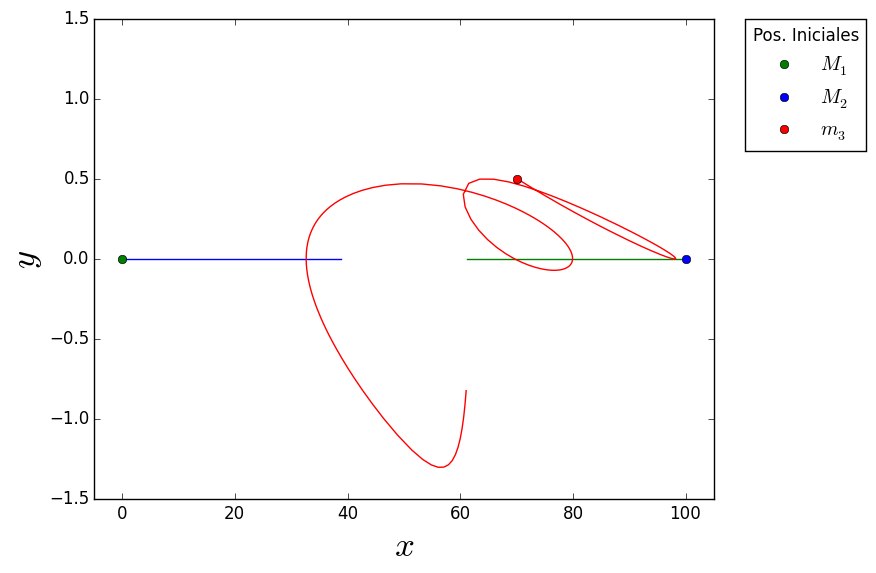

PyObject <matplotlib.legend.Legend object at 0x7f0545a597d0>

In [10]:
plot(x1,y1);plot([0],[0],label=L"M_1","go");plot(x2,y2)
plot([100.0],[0.0],"bo",label=L"M_2");plot(x3,y3);plot([70.0],[0.5],"ro", label=L"m_3")
xlim([-5,105]);ylim([-1.5, 1.5])
xlabel(L"x",fontsize=25);ylabel(L"y",fontsize=25)
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,numpoints=1,title="Pos. Iniciales")

In [16]:
function condInic{T<:Real}(a::T)
    x01=0.0 
    y01=0.0
    vx01=0.0
    vy01=0.0 
    x02=100.0
    y02=0.0
    vx02=0.0
    vy02=0.001 #Aquí será el mismo que el de arriba, sólo que le doy un pequeño empujón a M2
    x03=70.0
    y03=0.5
    vx03=0.0
    vy03=0.0
    return x01,y01,vx01,vy01,x02,y02,vx02,vy02,x03,y03,vx03,vy03
end
t, x1, y1, x2, y2, x3, y3= Integration(750.0,jet)

([0.0,43.8714,76.8006,102.394,122.25,137.627,149.512,158.682,165.744,171.132  …  744.819,745.867,746.703,747.384,747.953,748.45,748.901,749.331,749.765,750.223],[0.0,0.0962969,0.295499,0.526075,0.75102,0.953119,1.12616,1.26977,1.3864,1.47892  …  38.3329,38.5239,38.6777,38.804,38.9102,39.0034,39.0886,39.1703,39.253,39.3407],[0.0,1.40949e-5,7.58578e-5,0.000180444,0.000308205,0.000441181,0.000567226,0.000679711,0.000776026,0.000855477  …  0.160922,0.162662,0.164077,0.165248,0.16624,0.167116,0.16792,0.168694,0.169483,0.170323],[100.0,99.9037,99.7045,99.4739,99.249,99.0469,98.8738,98.7302,98.6136,98.5211  …  61.6671,61.4761,61.3223,61.196,61.0898,60.9966,60.9114,60.8297,60.747,60.6593],[0.0,0.0438573,0.0767248,0.102214,0.121942,0.137186,0.148945,0.158003,0.164968,0.170277  …  0.583897,0.583205,0.582626,0.582136,0.581713,0.581334,0.580981,0.580637,0.580282,0.5799],[70.0,70.885,72.7976,75.1711,77.6897,80.1717,82.5147,84.6646,86.5985,88.2987  …  58.3246,59.1322,59.8163,60.4029,60.9104,61.3573,

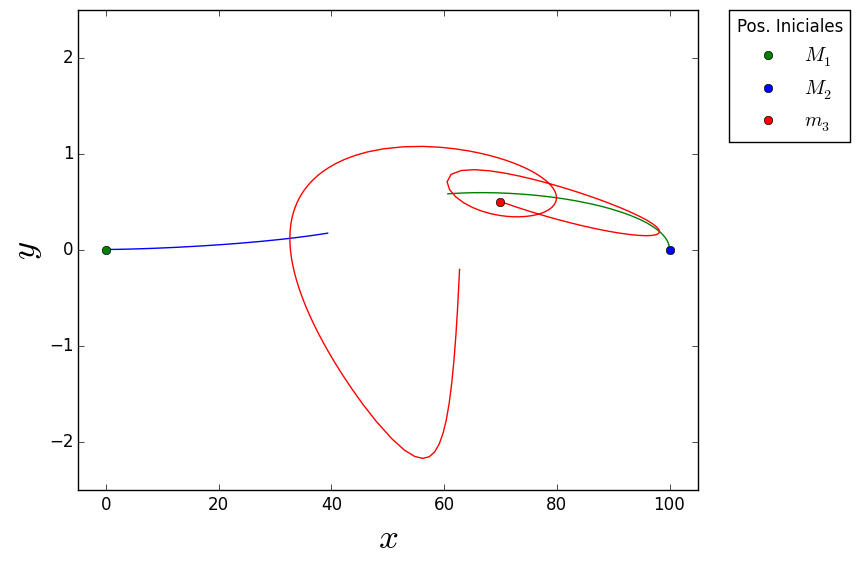

PyObject <matplotlib.legend.Legend object at 0x7f05456a8f90>

In [17]:
plot(x1,y1);plot([0],[0],label=L"M_1","go");plot(x2,y2)
plot([100.0],[0.0],"bo",label=L"M_2");plot(x3,y3);plot([70.0],[0.5],"ro", label=L"m_3")
xlim([-5,105]);ylim([-2.5, 2.5])
xlabel(L"x",fontsize=25);ylabel(L"y",fontsize=25)
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,numpoints=1,title="Pos. Iniciales")

## 2) Dos cuerpos se mueven. 

In [29]:
function condInic{T<:Real}(a::T)
    x01=0.0 
    y01=0.0
    vx01=0.0
    vy01=0.0 
    x02=100.0
    y02=0.0
    vx02=0.0
    vy02=0.0
    x03=70.0
    y03=0.5
    vx03=0.0
    vy03=0.0
    return x01,y01,vx01,vy01,x02,y02,vx02,vy02,x03,y03,vx03,vy03
end
t, x1, y1, x2, y2, x3, y3= Integration(1000.0,jet)

([0.0,43.8618,76.7872,102.378,122.231,137.606,149.49,158.659,165.719,171.106  …  947.105,949.81,953.157,957.3,962.428,968.78,976.609,986.198,994.366,1000.63],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[100.0,99.9038,99.7049,99.475,99.2511,99.0502,98.8784,98.736,98.6205,98.5289  …  44.2837,43.8526,43.3141,42.6393,41.7908,40.7188,39.364,37.6505,36.1396,34.9458],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[70.0,70.8847,72.7973,75.1714,77.6913,80.1749,82.5194,84.6708,86.6059,88.3071  …  7.78315,8.85103,10.0523,11.4011,12.9144,14.6168,16.5404,18.7596,20.6434,22.1666],[0.5,0.480632,0.439534,0.389911,0.338825,0.289988,0.245229,0.205303,0.170356,0.140432  …  0.301041,0.317541,0.333286,0.347592,0.359508,0.367685,0.370103,0.363562,0.34995,0.333453])

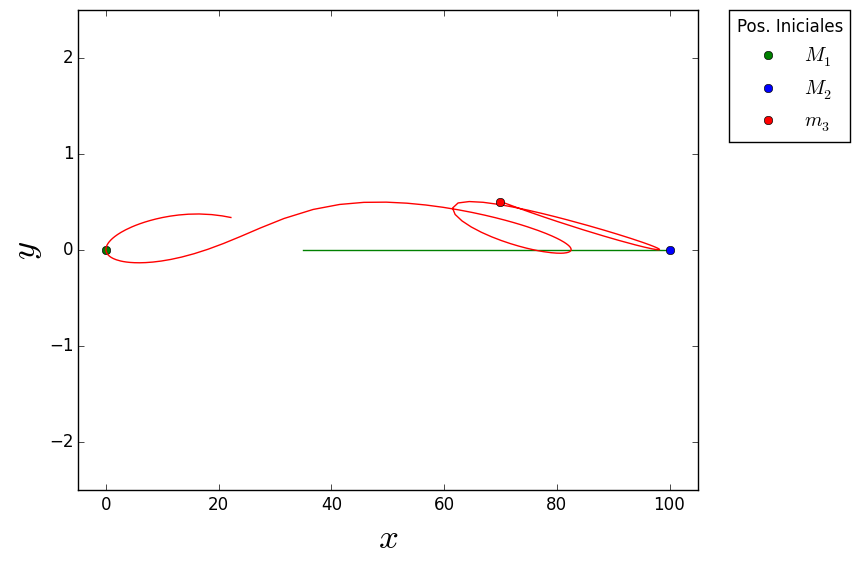

PyObject <matplotlib.legend.Legend object at 0x7f05452378d0>

In [30]:
plot(x1,y1);plot([0],[0],label=L"M_1","go");plot(x2,y2)
plot([100.0],[0.0],"bo",label=L"M_2");plot(x3,y3);plot([70.0],[0.5],"ro", label=L"m_3")
xlim([-5,105]);ylim([-2.5, 2.5])
xlabel(L"x",fontsize=25);ylabel(L"y",fontsize=25)
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,numpoints=1,title="Pos. Iniciales")

In [64]:
function condInic{T<:Real}(a::T)
    x01=0.0 
    y01=0.0
    vx01=0.0
    vy01=0.0 
    x02=100.0
    y02=0.0
    vx02=0.0
    vy02=0.05 #Le doy un pequeño empujón a M2
    x03=95.0
    y03=0.5
    vx03=0.001 #También a m3
    vy03=0.0
    return x01,y01,vx01,vy01,x02,y02,vx02,vy02,x03,y03,vx03,vy03
end
t, x1, y1, x2, y2, x3, y3= Integration(3000.0,jet)

([0.0,2.87831,5.11533,6.82611,8.13558,9.13877,9.90801,10.4984,10.952,11.3007  …  2995.63,2995.83,2996.08,2996.39,2996.77,2997.24,2997.82,2998.54,2999.42,3000.51],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[100.0,99.9996,99.9987,99.9977,99.9967,99.9958,99.9951,99.9945,99.994,99.9936  …  96.0033,95.9974,95.9903,95.9814,95.9704,95.9569,95.9401,95.9195,95.8939,95.8622],[0.0,0.143916,0.255765,0.341303,0.406775,0.456932,0.495393,0.524911,0.547587,0.565024  …  13.887,13.8967,13.9087,13.9235,13.9418,13.9644,13.9922,14.0265,14.0688,14.1209],[95.0,95.168,95.5414,95.9951,96.4645,96.916,97.3332,97.7092,98.0425,98.3345  …  94.6803,94.4814,94.2568,94.0045,93.7223,93.4091,93.0654,92.6929,92.296,91.8838],[0.5,0.485054,0.455889,0.425846,0.400179,0.380638,0.367384,0.359877,0.357309,0.358815  …  14.3801,14.4237,14.4702,14.5197,14.5718,14.6264,14.6826,14.7396,14.796,14.85])

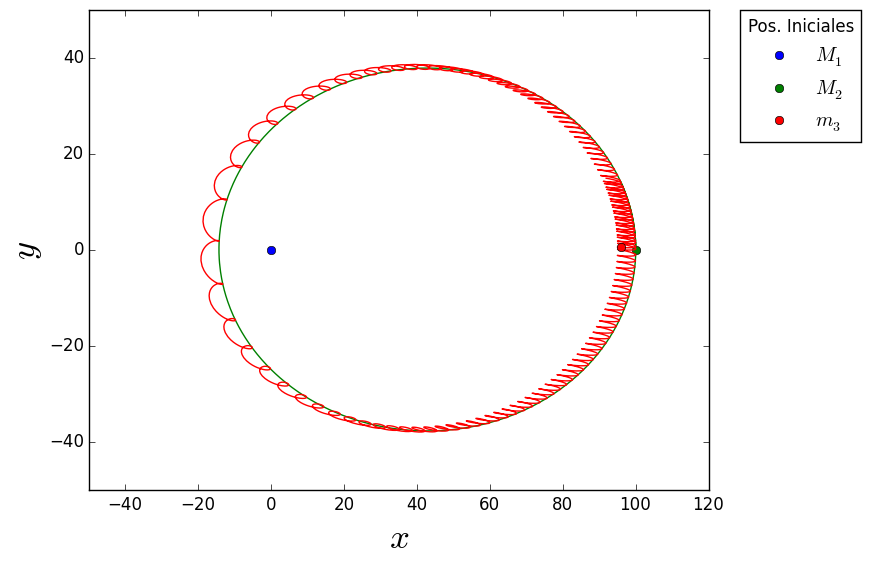

PyObject <matplotlib.legend.Legend object at 0x7f0543fbec90>

In [68]:
plot(x1,y1);plot([0],[0],label=L"M_1","bo");plot(x2,y2)
plot([100.0],[0.0],"go",label=L"M_2");plot(x3,y3);plot([96.0],[0.5],"ro", label=L"m_3")
xlim([-50,120]);ylim([-50, 50])
xlabel(L"x",fontsize=25);ylabel(L"y",fontsize=25)
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,numpoints=1,title="Pos. Iniciales")

## 3) Sólo $m_3$ se mueve.

In [28]:
function condInic{T<:Real}(a::T)
    x01=0.0 
    y01=0.0
    vx01=0.0
    vy01=0.0 
    x02=0.2
    y02=0.0
    vx02=0.0
    vy02=0.0
    x03=0.15
    y03=0.5
    vx03=0.0
    vy03=0.0
    return x01,y01,vx01,vy01,x02,y02,vx02,vy02,x03,y03,vx03,vy03
end
t, x1, y1, x2, y2, x3, y3= Integration(6.0,jet)

([0.0,0.0669008,0.120827,0.16182,0.192725,0.216761,0.236018,0.250552,0.262191,0.271236  …  5.63317,5.66411,5.70262,5.75029,5.8096,5.87495,5.92577,5.9642,5.99337,6.01625],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2  …  0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.15,0.148507,0.145015,0.140791,0.136531,0.132438,0.128564,0.125229,0.122288,0.119867  …  0.141743,0.14495,0.1478,0.149784,0.150078,0.147672,0.143682,0.139243,0.134892,0.130762],[0.5,0.483136,0.443559,0.395421,0.346437,0.298758,0.252713,0.211898,0.174245,0.141  …  -0.395458,-0.433341,-0.467534,-0.492507,-0.499179,-0.475757,-0.433376,-0.384724,-0.33595,-0.28857])

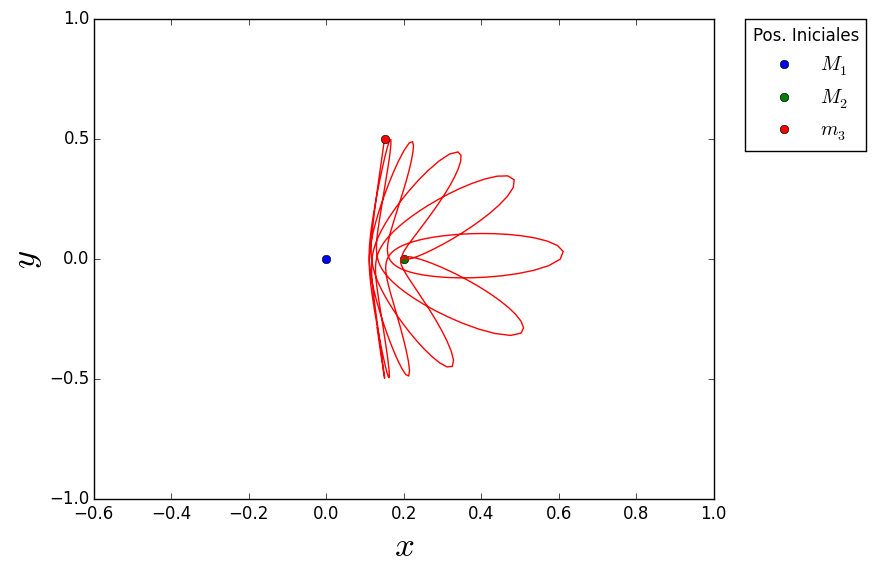

PyObject <matplotlib.legend.Legend object at 0x7f90dddca910>

In [29]:
plot(x1,y1);plot([0],[0],label=L"M_1","bo");plot(x2,y2)
plot([0.2],[0.0],"go",label=L"M_2");plot(x3,y3);plot([.15],[0.5],"ro", label=L"m_3")
xlim([-0.6,1.0]);ylim([-1.0, 1.0])
xlabel(L"x",fontsize=25);ylabel(L"y",fontsize=25)
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,numpoints=1,title="Pos. Iniciales")

In [82]:
function condInic{T<:Real}(a::T)
    x01=0.0 
    y01=0.0
    vx01=0.0
    vy01=0.0 
    x02=0.2
    y02=0.0
    vx02=0.0
    vy02=0.0
    x03=0.09
    y03=0.5
    vx03=0.1
    vy03=0.0
    return x01,y01,vx01,vy01,x02,y02,vx02,vy02,x03,y03,vx03,vy03
end
t, x1, y1, x2, y2, x3, y3= Integration(8.0,jet)

([0.0,0.0666373,0.12045,0.161054,0.191939,0.215968,0.235214,0.249736,0.261333,0.27039  …  7.78822,7.79941,7.81295,7.8295,7.85055,7.87522,7.90526,7.94242,7.98944,8.0486],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2  …  0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.09,0.0968955,0.102624,0.106865,0.109914,0.112075,0.113585,0.11453,0.115133,0.115518  …  0.103885,0.10191,0.0994991,0.0965606,0.0928808,0.0886959,0.0838311,0.0782159,0.0718179,0.06503],[0.5,0.483077,0.44326,0.395215,0.345908,0.297862,0.251449,0.210296,0.172434,0.138837  …  -0.205492,-0.238216,-0.273249,-0.310564,-0.351012,-0.390302,-0.4284,-0.463025,-0.489685,-0.498634])

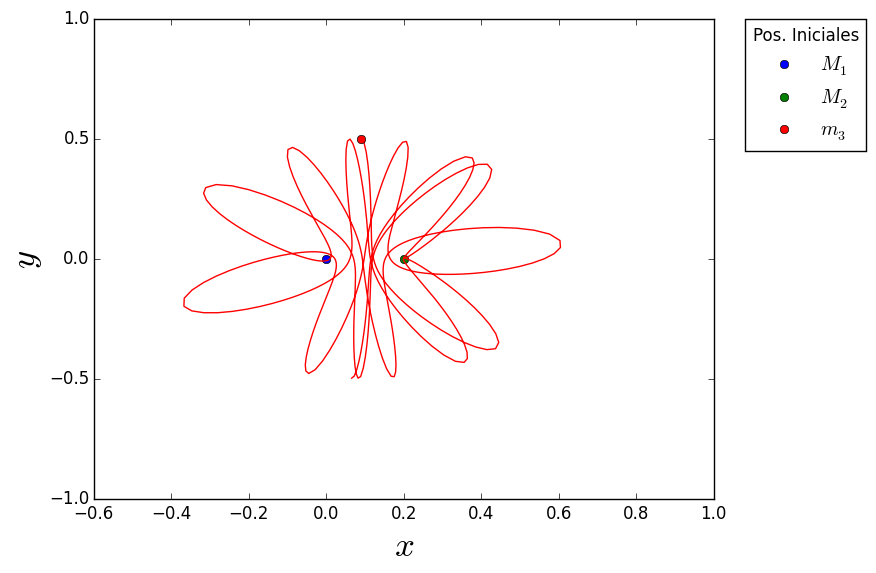

PyObject <matplotlib.legend.Legend object at 0x7f90dcaa7f10>

In [83]:
plot(x1,y1);plot([0],[0],label=L"M_1","bo");plot(x2,y2)
plot([0.2],[0.0],"go",label=L"M_2");plot(x3,y3);plot([.09],[0.5],"ro", label=L"m_3")
xlim([-0.6,1.0]);ylim([-1.0, 1.0])
xlabel(L"x",fontsize=25);ylabel(L"y",fontsize=25)
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,numpoints=1,title="Pos. Iniciales")

In [85]:
function condInic{T<:Real}(a::T)
    x01=0.0 
    y01=0.0
    vx01=0.0
    vy01=0.0 
    x02=0.2
    y02=0.0
    vx02=0.0
    vy02=0.0
    x03=0.09
    y03=0.2
    vx03=0.2
    vy03=0.0
    return x01,y01,vx01,vy01,x02,y02,vx02,vy02,x03,y03,vx03,vy03
end
t, x1, y1, x2, y2, x3, y3= Integration(8.0,jet)

([0.0,0.0226818,0.0391594,0.0523271,0.0634267,0.0717836,0.0782138,0.0836762,0.088249,0.0923441  …  7.92782,7.9322,7.937,7.94249,7.94882,7.9563,7.96523,7.97618,7.98933,8.00527],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2  …  0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.09,0.0946925,0.0982324,0.101087,0.103495,0.105345,0.106878,0.108413,0.110076,0.112113  …  0.107198,0.109865,0.113143,0.117219,0.122195,0.128237,0.135486,0.144174,0.154092,0.16508],[0.2,0.190696,0.171634,0.147886,0.120891,0.0955394,0.0726293,0.0506687,0.0306083,0.0116547  …  -0.0385695,-0.0571363,-0.0758073,-0.094919,-0.114186,-0.133452,-0.152151,-0.16946,-0.183109,-0.19024])

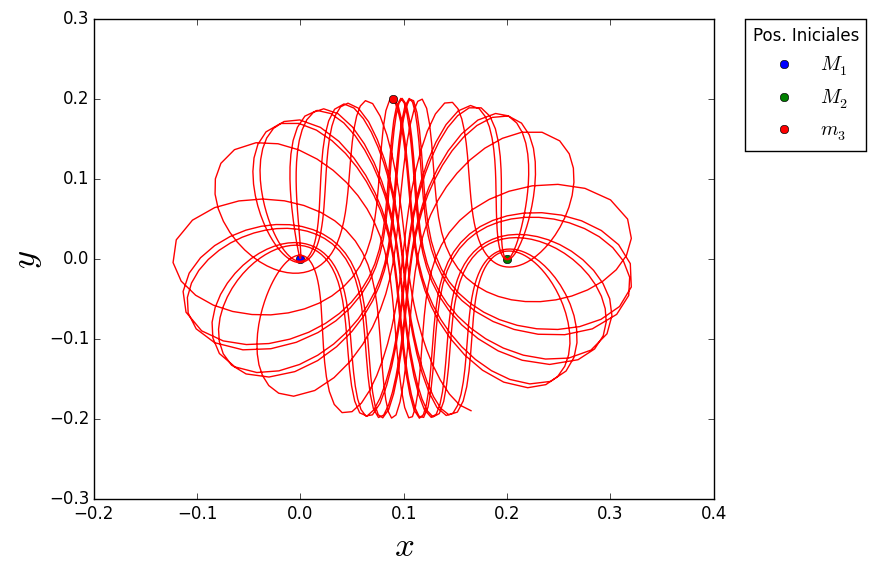

PyObject <matplotlib.legend.Legend object at 0x7f90dc6e5710>

In [89]:
plot(x1,y1);plot([0],[0],label=L"M_1","bo");plot(x2,y2)
plot([0.2],[0.0],"go",label=L"M_2");plot(x3,y3);plot([.09],[0.2],"ro", label=L"m_3")
xlim([-0.2,0.4]);ylim([-0.3, 0.3])
xlabel(L"x",fontsize=25);ylabel(L"y",fontsize=25)
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,numpoints=1,title="Pos. Iniciales")

In [107]:
function condInic{T<:Real}(a::T)
    x01=0.0 
    y01=0.0
    vx01=0.0
    vy01=0.0 
    x02=0.2
    y02=0.0
    vx02=0.0
    vy02=0.0
    x03=8.0
    y03=-6.0
    vx03=0.2
    vy03=0.0
    return x01,y01,vx01,vy01,x02,y02,vx02,vy02,x03,y03,vx03,vy03
end
t, x1, y1, x2, y2, x3, y3= Integration(200.0,jet)

([0.0,4.47146,9.99245,16.4596,21.4193,25.2215,28.1408,30.3863,32.0999,33.4118  …  162.985,165.307,168.168,171.698,176.057,181.444,188.0,193.146,197.088,200.089],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2  …  0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[8.0,8.73694,9.22775,9.20709,8.70668,7.97685,7.15628,6.32253,5.52694,4.79078  …  6.68455,7.55194,8.43055,9.26725,9.96978,10.3761,10.1954,9.49389,8.56267,7.56755],[-6.0,-5.8847,-5.45845,-4.60589,-3.70468,-2.86377,-2.12303,-1.49201,-0.972069,-0.551146  …  -3.6617,-3.72238,-3.70229,-3.56799,-3.27411,-2.75897,-1.95386,-1.21157,-0.591215,-0.0984692])

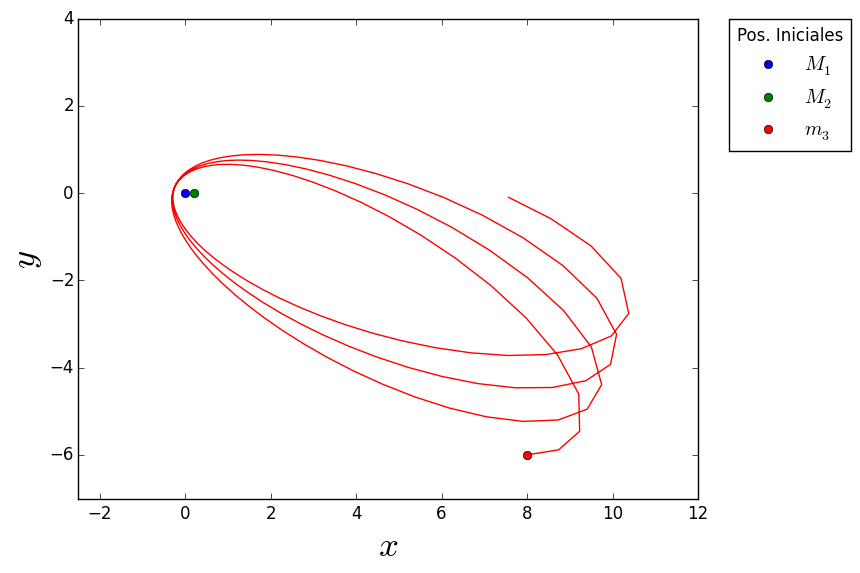

PyObject <matplotlib.legend.Legend object at 0x7f90dbdea210>

In [110]:
plot(x1,y1);plot([0],[0],label=L"M_1","bo");plot(x2,y2)
plot([0.2],[0.0],"go",label=L"M_2");plot(x3,y3);plot([8.0],[-6.0],"ro", label=L"m_3")
xlim([-2.5,12]);ylim([-7, 4])
xlabel(L"x",fontsize=25);ylabel(L"y",fontsize=25)
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,numpoints=1,title="Pos. Iniciales")

Nota: para realizar todas estas gráficas se tuvo que modificar Integration de acuerdo a lo que se quería (hay código comentado).

### Problemas que se tuvieron (y resolvieron):
1) Tipográficos (muchos... demasiados...)

2) Paso de tiempo muy pequeño que no permitía evolucionar.*

3) División de series de Taylor con primer coeficiente distinto de cero.

4) Necedad.

### Coming soon (propuestas para continuar con esto):

1) Resolver con el mismo método, y "diferentes" ecuaciones(Hamiltoniano,  Lagrangiano)

2) Con esto, comprobar que se conserva la integral de Jacobi.

3) Explorar más posibilidades de condiciones iniciales.